In [1]:
import os
import sys
sys.path.append('../')
import torch
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
from pointnet.dataset import PhaseDataset
from pointnet.model_stn import PointNetCls
import torch.nn.functional as F
import numpy as np
np.set_printoptions(precision=6)
from scipy.special import softmax

In [2]:
def update_json_val(n_clouds, phase, guess, json_path):
    data = []
    for j in range(1, n_clouds + 1):
        data.append('"shape_data/%s/coord_O_%s_%d"' %(guess, phase, j))    
    with open(json_path,'w') as f:
        f.write('[')
        for k in range(len(data) - 1):
            f.write(data[k] + ',')
        f.write(data[-1] + ']')

json_path = '../data/point_clouds/train_test_split/shuffled_val_file_list.json'
phase = 'dd_glyco'
guess = 'dd'
update_json_val(50, phase, guess, json_path)

In [3]:
model_path = '../trained_models/model_C/'
num_points = 1000


test_dataset = PhaseDataset(
        root='../data/point_clouds',
        split='val',
        classification=True,
        npoints=num_points,
        data_augmentation=False)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False)

num_classes = len(test_dataset.classes)
classifier = PointNetCls(k=num_classes, feature_transform=False)
classifier.cuda()

def evaluate(test_dataset, test_dataloader, classifier, model):
    pred_class = []
    tot_loss = 0   
    pred_all = np.zeros((0,9))   
    for i, data in enumerate(test_dataloader, 0):
        points, target = data
        target = target[:, 0].cuda()
        points = points.transpose(2, 1).cuda()
        classifier = classifier.eval()
        pred, _, _ = classifier(points)
        loss = F.nll_loss(pred, target)
        pred_all = np.vstack([pred_all, pred.cpu().detach().numpy()])
        print('model: {}\tbatch: {}\tloss: {}'.format(model_idx, i, loss.data.item()))
        tot_loss += loss.data
        
    return pred_all, tot_loss

min_loss = float("inf")
best_model_idx = 0
pred_final = None
for model_idx in range(81, 100):
    model= os.path.join(model_path, 'cls_model_{}.pth'.format(model_idx))
    classifier.load_state_dict(torch.load(model), strict=False)
    pred_all, tot_loss = evaluate(test_dataset, test_dataloader, classifier, model)
    if tot_loss < min_loss:
        min_loss = tot_loss
        pred_final = pred_all
        best_model_idx = model_idx
print('Best model: {}'.format(best_model_idx))
scores = softmax(pred_final, axis =1)
    
    

{'BCC': 0, 'DD': 1, 'DG': 2, 'DIS': 3, 'HPC': 4, 'HPL': 5, 'LAM': 6, 'P': 7, 'SG': 8}
{'LAM': 1, 'HPC': 1, 'HPL': 1, 'BCC': 1, 'DIS': 1, 'SG': 1, 'DG': 1, 'DD': 1, 'P': 1} 1
model: 81	batch: 0	loss: 0.3411647379398346
model: 81	batch: 1	loss: 0.15418928861618042
model: 82	batch: 0	loss: 0.4114432632923126
model: 82	batch: 1	loss: 0.6437581181526184
model: 83	batch: 0	loss: 0.659503698348999
model: 83	batch: 1	loss: 0.04851318895816803
model: 84	batch: 0	loss: 0.27888840436935425
model: 84	batch: 1	loss: 0.29714152216911316
model: 85	batch: 0	loss: 0.3996909558773041
model: 85	batch: 1	loss: 0.0868503749370575
model: 86	batch: 0	loss: 0.2309407889842987
model: 86	batch: 1	loss: 0.12198417633771896
model: 87	batch: 0	loss: 0.26949724555015564
model: 87	batch: 1	loss: 0.06079849228262901
model: 88	batch: 0	loss: 0.2771943211555481
model: 88	batch: 1	loss: 0.04116285964846611
model: 89	batch: 0	loss: 0.3161860406398773
model: 89	batch: 1	loss: 0.01701296865940094
model: 90	batch: 0	loss: 0

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
class Visualize:
    def __init__(self, scores):
        self.scores = scores
        self.labels = {'BCC': 1, 'DD': 2, 'DG': 3, 'DIS': 4, 'HPC': 5, 'HPL': 6, 'LAM': 7, 'P': 8, 'SG': 9}
        self.figsize = (6.5, 4)
        
    def plot_softmax_scores_stack(self):
        x = np.arange(1, 1 + scores.shape[0]) 
        fig, ax = plt.subplots(1,figsize=self.figsize)
        ax.stackplot(x, scores[:,0], scores[:,1], scores[:,2], 
                     scores[:,3], scores[:,4], scores[:,5], 
                     scores[:,6], scores[:,7], scores[:,8],
                    alpha = 0.88)
        ax.legend(self.labels, bbox_to_anchor=(1.31, 1.03), fontsize = 16)
        ax.tick_params(direction='in', width = 1)
        ax.set_ylim([0, 1])
        ax.set_xlabel('Frame Index')
        ax.set_ylabel('Softmax Probability')
        plt.show()
    
    def plot_cand_hist(self):
        freq = {i:0 for i in range(len(self.labels))}
        for i in range(scores.shape[0]):
            freq[np.argmax(scores[i,:])] += 1
        fig, ax = plt.subplots(1,figsize=self.figsize)
        ax.bar(range(len(self.labels)), list(freq.values()) / np.sum(list(freq.values())), align='center')
        ax.set_xlabel('Structures')
        ax.set_ylabel('Frequency')
        ax.set_ylim([0, 1])
        ax.tick_params(direction='in', width = 1, )
        tick_spacing = 1
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))  
        labels = [''] + list(self.labels.keys())
        ax.set_xticklabels(labels)
        fig.tight_layout()

viz = Visualize(scores)


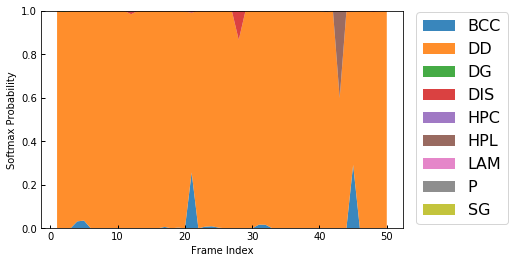

In [5]:
viz.plot_softmax_scores_stack()

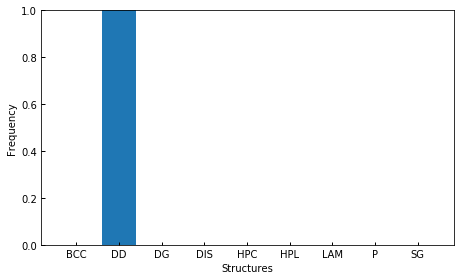

In [6]:
viz.plot_cand_hist()